## Import Libraries

In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Reshape, concatenate, RepeatVector
import numpy as np
from tensorflow.keras.initializers import TruncatedNormal
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import tensorflow_io as tfio
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

## Setup GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPUs: {len(gpus)}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Available GPUs: 1


## Load the Dataset

In [3]:
DIRECTORY = 'Faces/Train/'
data = []
for image in os.listdir(DIRECTORY):
    data.append(img_to_array(load_img(DIRECTORY+image)))

NUM_IMAGES = len(data)
print(f'Images Found: {NUM_IMAGES}')
data = np.array(data, dtype=np.float32)

Images Found: 550


## Visualize the Dataset

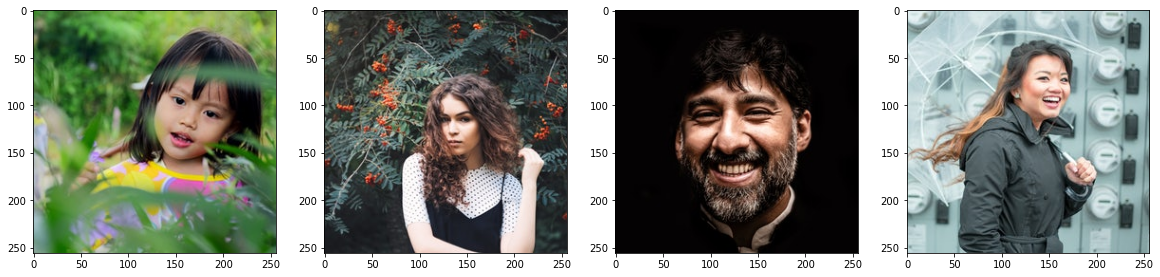

In [5]:
_, ax = plt.subplots(ncols=4, figsize=(20,20))
sample_indices = np.random.choice(NUM_IMAGES, 4)
for i in range(4): 
    image = data[sample_indices[i]]
    ax[i].imshow(tf.cast(image, tf.int32))

## Instantiate an Inception-ResNet v2 Model to Extract High-Level Features

In [6]:
inception_resnet_model = InceptionResNetV2(include_top=True, weights='imagenet',
                                          classifier_activation=None)
# Since we only need the output of the last layer before the softmax function, activation is set to None

## Prepare Dataset

#### Create an Image Generator

In [7]:
image_generator = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True)

#### Create the Dataset Generator

In [8]:
def dataset_generator(batch_size=10):
    for image_batch in image_generator.flow(data, batch_size=batch_size):
        image_batch = tf.cast(image_batch, dtype=tf.float32)
        lab_image = image_batch / 255.0

        # Convert to LAB encoding
        lab_image = tfio.experimental.color.rgb_to_lab(lab_image, illuminant='D65', observer='2') / 128
        # Resize to 224 × 224 
        lab_image = tf.image.resize(lab_image, (224, 224))

        # Remove the L dimension for the decoder branch
        dec_image = lab_image[:,:,:,1:]

        # Store the L dimension for the grayscale image
        enc_image = lab_image[:,:,:,:1]

        # Resize to 299 × 299  for the Inception-ResNet v2 Model
        inc_image = tf.image.resize(tf.image.rgb_to_grayscale(image_batch), (299, 299))

        # Make the inc_image three-dimensional
        inc_image = tf.reshape(inc_image, (-1, 299, 299))
        inc_image = tf.stack((inc_image,inc_image,inc_image),axis=3)

        # Center and scale the pixel values in order to obtain values within the interval of [−1, 1]
        inc_image = preprocess_input(inc_image)

        # Pass the inc_image through the Inception ResNet v2 Model
        features = inception_resnet_model(inc_image)

        yield {'enc_image':enc_image, 'features':features}, dec_image

## Create Deep CNN

### Encoder Architecture

In [9]:
enc_input = Input(shape=(224,224,1), name='EncoderInput')

conv_layer = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE1')(enc_input)
conv_layer = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE2')(conv_layer)
conv_layer = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE3')(conv_layer)
conv_layer = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE4')(conv_layer)
conv_layer = Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE5')(conv_layer)
conv_layer = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE6')(conv_layer)
conv_layer = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE7')(conv_layer)
enc_output = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerE8')(conv_layer)

### Fusion Architecture

In [10]:
fusion_input = Input(shape=(1000), name='FusionInput')

repeat_layer = RepeatVector(28*28, name='RepeatLayer')(fusion_input)
reshape_layer = Reshape([28,28,1000], name='ReshapeLayer')(repeat_layer)
conc_layer = concatenate([enc_output, reshape_layer], axis=3)

fusion_output = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),  activation='relu',
              name='Conv2D_LayerF1')(conc_layer)

### Decoder Architecture

In [11]:
conv_layer = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD1')(fusion_output)
upsamp_layer = UpSampling2D(size=(2,2), name='UpSampling_D1')(conv_layer)

conv_layer = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD2')(upsamp_layer)
upsamp_layer = UpSampling2D(size=(2,2), name='UpSampling_D2')(conv_layer)

conv_layer = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD3')(upsamp_layer)
conv_layer = Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='tanh',
              name='Conv2D_LayerD4')(conv_layer)

dec_output = UpSampling2D(size=(2,2), name='UpSampling_D3')(conv_layer)

### Connected Model

In [12]:
coloriser = tf.keras.Model(inputs={'enc_image':enc_input, 'features':fusion_input}, outputs=dec_output, name='ColoriserModel')
coloriser.summary()

Model: "ColoriserModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2D_LayerE1 (Conv2D)        (None, 112, 112, 64  640         ['EncoderInput[0][0]']           
                                )                                                                 
                                                                                                  
 Conv2D_LayerE2 (Conv2D)        (None, 112, 112, 12  73856       ['Conv2D_LayerE1[0][0]']         
                                8)                                                   

## Compile CNN Model

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error as mse

In [13]:
coloriser.compile(optimizer=Adam(learning_rate=0.001), loss=mse, metrics = ['accuracy'])

## Train the Model

In [113]:
training_history = coloriser.fit(dataset_generator(batch_size=10), epochs=300, steps_per_epoch=30)

Epoch 1/300
30/30 [==============================] - 21s 702ms/step - loss: 0.0087 - accuracy: 0.5693
Epoch 2/300
30/30 [==============================] - 22s 750ms/step - loss: 0.0088 - accuracy: 0.6235
Epoch 3/300
30/30 [==============================] - 23s 761ms/step - loss: 0.0085 - accuracy: 0.5864
Epoch 4/300
30/30 [==============================] - 27s 900ms/step - loss: 0.0084 - accuracy: 0.5877
Epoch 5/300
30/30 [==============================] - 29s 967ms/step - loss: 0.0079 - accuracy: 0.5947
Epoch 6/300
30/30 [==============================] - 24s 814ms/step - loss: 0.0080 - accuracy: 0.5515
Epoch 7/300
30/30 [==============================] - 23s 756ms/step - loss: 0.0086 - accuracy: 0.6264
Epoch 8/300
30/30 [==============================] - 24s 784ms/step - loss: 0.0082 - accuracy: 0.5922
Epoch 9/300
30/30 [==============================] - 23s 758ms/step - loss: 0.0083 - accuracy: 0.5800
Epoch 10/300
30/30 [==============================] - 23s 761ms/step - loss: 0.008

## Visualize the Training History

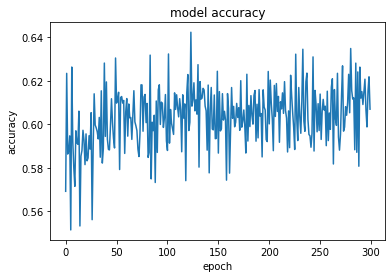

In [ ]:
plt.plot(training_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

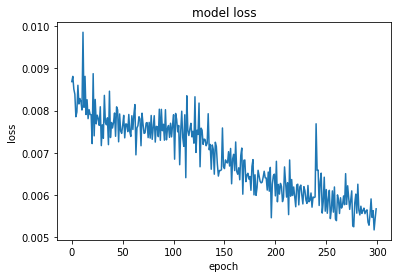

In [116]:
plt.plot(training_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Save Model, Train Again, Repeat

Since it is not feasible to train the model at once for 1000 epochs in a personal computer, I have trained it in batches of 300 epochs. However, only the first batch of 300 epochs is shown.

In [14]:
coloriser = tf.keras.models.load_model('coloriser_model.h5')

! Train again

In [15]:
coloriser.save('coloriser_model.h5')

## Load Test Images

In [16]:
test = []
TEST_DIR = 'Faces/Test/'
for image in os.listdir(TEST_DIR):
    test.append(img_to_array(load_img(TEST_DIR+image)))
NUM_TEST_IMG = len(test)
print(f'Available Images: {NUM_TEST_IMG}')

Available Images: 25


## Feed the Images to the Model

In [17]:
def feed(images):
    images = tf.cast(images, dtype=tf.float32)
    lab_image = images / 255.0

    # Convert to LAB encoding
    lab_image = tfio.experimental.color.rgb_to_lab(lab_image, illuminant='D65', observer='2') / 128
    # Resize to 224 × 224 
    lab_image = tf.image.resize(lab_image, (224, 224))

    # Store the L dimension for the grayscale image
    enc_image = lab_image[:,:,:,:1]

    # Resize to 299 × 299  for the Inception-ResNet v2 Model
    inc_image = tf.image.resize(tf.image.rgb_to_grayscale(images), (299, 299))

    # Make the inc_image three-dimensional
    inc_image = tf.reshape(inc_image, (-1, 299, 299))
    inc_image = tf.stack((inc_image,inc_image,inc_image),axis=3)

    # Center and scale the pixel values in order to obtain values within the interval of [−1, 1]
    inc_image = preprocess_input(inc_image)

    # Pass the inc_image through the Inception ResNet v2 Model
    features = inception_resnet_model(inc_image)
    
    outputs = coloriser.predict({'enc_image':enc_image,'features':features})
    return outputs, enc_image

In [18]:
pred, enc_image = feed(test)

1/1 [==============================] - 3s 3s/step


## Visualize the Output

In [19]:
pred.shape

(25, 224, 224, 2)

In [20]:
enc_image.shape

TensorShape([25, 224, 224, 1])

In [21]:
images = np.zeros((NUM_TEST_IMG, 224,224,3))
images[:,:,:,0] = enc_image[:,:,:,0]
images[:,:,:,1:] = pred[:,:,:,:]
images.shape

(25, 224, 224, 3)

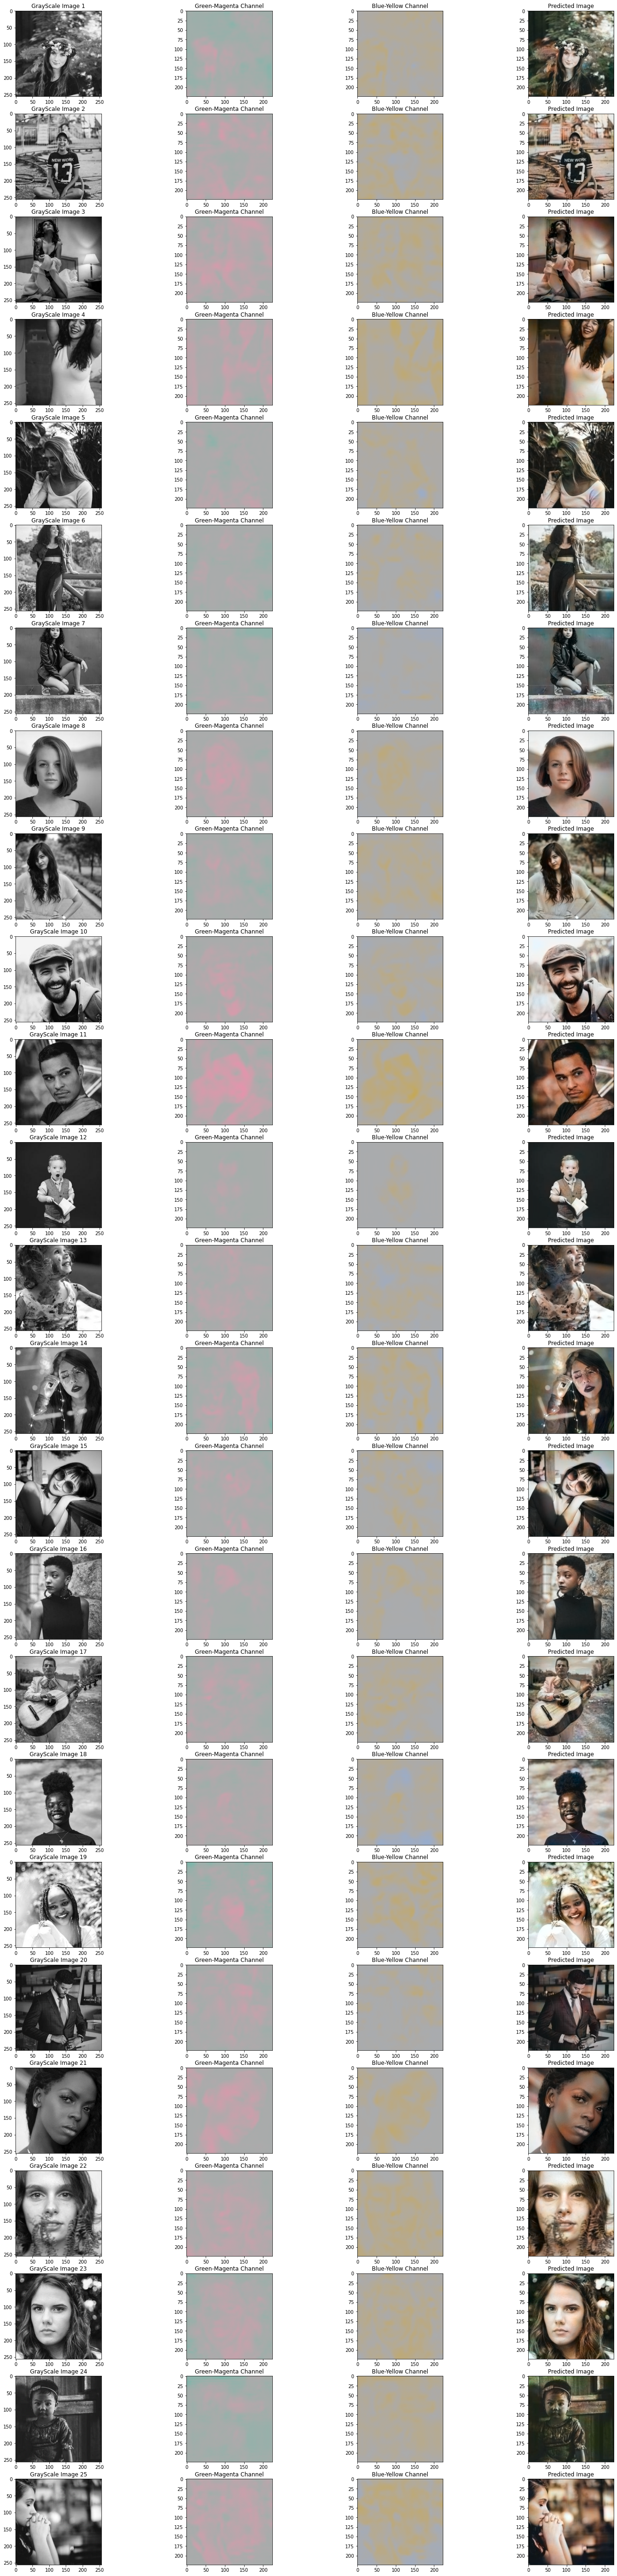

In [22]:
_, ax = plt.subplots(NUM_TEST_IMG, 4, figsize=(25,100))
for i in range(NUM_TEST_IMG):
    img = images[i]
    img = img * 128
    lab_a = np.zeros(img.shape)
    lab_b = np.zeros(img.shape)
    lab_a[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'a'
    lab_b[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'b'
    lab_a[:,:,1] = img[:,:,1]
    lab_b[:,:,2] = img[:,:,2]
    img = tfio.experimental.color.lab_to_rgb(img, illuminant='D65', observer='2')
    lab_a = tfio.experimental.color.lab_to_rgb(lab_a, illuminant='D65', observer='2')
    lab_b = tfio.experimental.color.lab_to_rgb(lab_b, illuminant='D65', observer='2')
    ax[i][0].imshow(tf.cast(test[i], tf.int32))
    ax[i][0].title.set_text('GrayScale Image '+str(i+1))
    ax[i][1].imshow(lab_a)
    ax[i][1].title.set_text('Green-Magenta Channel')
    ax[i][2].imshow(lab_b)
    ax[i][2].title.set_text('Blue-Yellow Channel')
    ax[i][3].imshow(img)
    ax[i][3].title.set_text('Predicted Image')
    name = 'Faces/Results/predimage'+str(i+1)+'.jpg'
    tf.keras.utils.save_img(name,img)
    